In [2]:
%matplotlib inline
from deep_net_topics import test_deepnet, Config, plot_stats

# Simple 2-layer Deepnet

Here are parameters for the configuration tested below, this is the one that has given me the best accuracy/auc so far.

## Architecture:
**Input**: 137 Features, 88 congressman-level + 50 Topics.

**Layer 1**: 64 units, RELU activation, L2 regularization

**Layer 2**: 16 units, RELU activation, L2 regularization

**output**: softmax activation, L2 regularization

## Hyperparameters
1. batch_size = 64
2. total epochs = 100
3. learning rate = 1e-2
4. regularization coefficient = 0.01
5. dropout probability = 0.1

## Notes
1. **Adding layers** doesn't imporove accuracy and causes optimizer to get stuck on local minima. Same goes for changing layer sizes.
2. **Lower learning rate** doesn't decrease final loss, higher leads to slightly worse optima.
3. **Different activation functions** on the hidden layers massively decrease performace both in terms of accuracy and auc.
4. **Sample weights**. Given how skewed the classes are it would seem that weighting predictions by the ratio of one class to another (common practice for dealing with skewed classes) may be a good idea. So far I've found that:
    * when nays are upweighted the model predicts more of them, leading to better AUC but worse accuracy
    * when nays are not upweighted the model has higher accuracy but slightly lower AUC, making this the better option for the time being. 
    * the optimizer stops at the same local minimum in both cases. 
5. **In general**: Works as expected. Improvement in accuracy is tiny over all yea, but auc increases massively.

## Final Stats
### Unweighted samples
1. Training set accuracy: .8927 (baseline all yea: .79)
2. Validation set accuracy: 0.8544 (baseline all yea: .84)
3. Training set AUC: 0.9009 (baseline all yea: .5)
4. Validation set AUC: 0.9500 (baseline all yea: .5)

### Weighted samples
1. Training set accuracy: .748 (baseline all yea: .79)
2. Validation set accuracy: 0.643 (baseline all yea: .84)
3. Training set AUC: 0.323 (baseline all yea: .5)
4. Validation set AUC: 0.98 (baseline all yea: .5)


In [5]:
config = Config()
config.max_epochs = 100
model = test_deepnet(config)

Loss at epoch 0: 10.51 (1.917 sec)
Training accuracy 0.79656, 252 nays predicted, auc: 0.201754
Validation accuracy 0.84005, 3 nays predicted, auc: 0.785641
Loss at epoch 1: 4.80 (1.921 sec)
Training accuracy 0.70405, 26906 nays predicted, auc: 0.268170
Validation accuracy 0.66817, 763 nays predicted, auc: 0.889231
Loss at epoch 2: 4.03 (1.940 sec)
Training accuracy 0.53900, 59025 nays predicted, auc: 0.689223
Validation accuracy 0.42270, 1704 nays predicted, auc: 0.881026
Loss at epoch 3: 3.56 (1.913 sec)
Training accuracy 0.56177, 55694 nays predicted, auc: 0.641604
Validation accuracy 0.46464, 1560 nays predicted, auc: 0.890256
Loss at epoch 4: 3.18 (2.540 sec)
Training accuracy 0.59830, 50077 nays predicted, auc: 0.468672
Validation accuracy 0.51316, 1340 nays predicted, auc: 0.896410
Loss at epoch 5: 2.86 (2.606 sec)
Training accuracy 0.60184, 50048 nays predicted, auc: 0.466165
Validation accuracy 0.51151, 1334 nays predicted, auc: 0.903590
Loss at epoch 6: 2.58 (3.044 sec)
Train

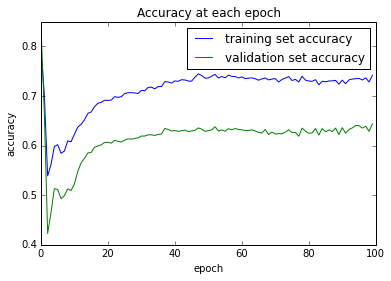

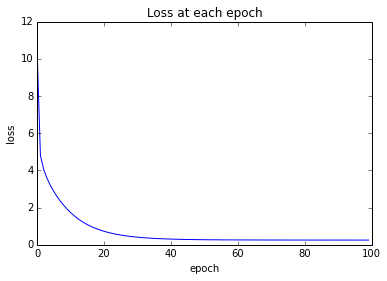

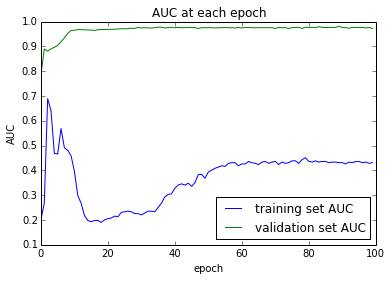

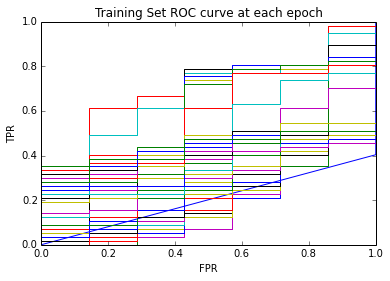

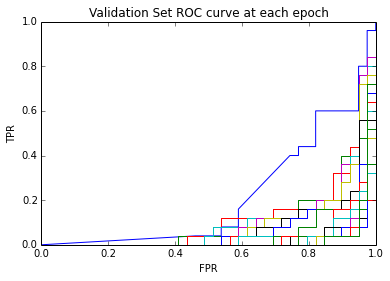

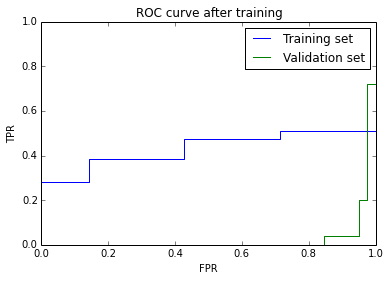

In [6]:
plot_stats(model, config)

## Easy fixes
1. Implement batch renormalization (not sure if it will do anything in our case)
2. Implement test predictions
3. Find optimal sample weighting

## Ways to Improve the model

I can come up with at lest 3 ways in which we can take this forward and make it more interesting from a theoretical perspective, even if accuracy isn't improved. Keep well in mind that these 3 are not mutually exclusive and it's likely that the best possible model implements all three:

1. **Embeddings** Do the feature reduction on the bill text ourselves, by implementing an autoencoder as a step of our prediction model in a way such that embeddings are optimized for prediction, rather than text reconstruction. 

2. **Recurrent Net**: This model treats each observation as IID, which isn't the case. We could force the model to take into account both the voting history of each congressman and of all the other congressmen in relation to each specific one with a recurrent network. 

3. **Convolutional Net** In order to best model the voting dependencies of one congressman on others, we could treat all the votes on a bill as a datapoint, I.E: a matrix with congressmen on both rows and columns and wether they voted in the same way on that bill or didn't. This would effectively be the same as an image and we could use convolutions to reduce input and make predictions. Mixing this with history dependence(RNN) would make for a pretty awesome end product. 